# 12. Contraste de modelos - quitando las variables importantes

## Importamos paquetes necesarios

In [1]:
import pandas as pd
import numpy as np
import pydotplus

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

from skopt import gp_minimize
from skopt.space import Categorical, Dimension, Integer, Real  # noqa

from IPython.display import Image  

import graphviz_tools as agt
import mlflow_utils as a_mlflow_u
import tree_utils as atu

## Cargamos nuestros dataset

In [2]:
file_cervezas_unicas_resumen_valores_con_clase_training = 'dataset/cervezas_unicas_resumen_valores_con_clase_train.csv'
file_cervezas_unicas_resumen_valores_con_clase_testing = 'dataset/cervezas_unicas_resumen_valores_con_clase_test.csv'

campos = [
    'beer_abv', 
    'review_aroma', 
    'review_appearance', 
    'review_taste', 
    'review_overall', 
    'review_palate', 
    'es_popular'
]

df_training_validacion = pd.read_csv(file_cervezas_unicas_resumen_valores_con_clase_training)
df_testing = pd.read_csv(file_cervezas_unicas_resumen_valores_con_clase_testing)

df_training_validacion = df_training_validacion.loc[:, campos]
df_testing = df_testing.loc[:, campos]

df_training_validacion.head()

,beer_abv,review_aroma,review_appearance,review_taste,review_overall,review_palate,es_popular
0,6.0,3.564000,3.736000,3.592000,3.776000,3.620000,NO
1,4.5,2.608108,3.351351,2.743243,2.945946,3.054054,NO
2,4.4,3.727273,3.727273,3.545455,3.545455,3.545455,NO
3,7.5,3.750000,3.500000,3.750000,3.750000,4.000000,NO
4,7.8,2.500000,3.500000,3.500000,3.500000,3.500000,NO


In [3]:
random_state = 1
test_size = 0.3

atributos = [
    'beer_abv', 
    'review_aroma', 
    'review_appearance', 
    'review_taste', 
    #'review_overall', 
    'review_palate'
]
clase = ['es_popular']

Y_df_training_validacion = df_training_validacion.loc[:, clase]
df_training_validacion = df_training_validacion.loc[:, atributos]

### Tambien abrimos en X e Y el dataset de testing

In [4]:
X_testing = df_testing.loc[:, atributos]
Y_testing = df_testing.loc[:, clase]

## Optimización del modelo

In [5]:
def cv_con_umbral_de_corte(params):
    umbral_corte = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    max_features = params[3]
    
    X = df_training_validacion
    y = Y_df_training_validacion
    #criterion='entropy'
    criterion='gini'
    #criterion='log_loss'
    clf = DecisionTreeClassifier(
                criterion = criterion,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                max_features=max_features,
                random_state=1
            )

    # 5-fold cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    def all_metrics(clf, X, y):
        y_pred = clf.predict_proba(X)
        df_y_pred_proba = pd.DataFrame(y_pred, columns = ['NO_prob', 'SI_prob'])
        y_pred = atu.evaluar_corte(df_y_pred_proba['NO_prob'].values, umbral_corte, 'SI', 'NO')

        metricas = atu.calcular_metricas(
            y_true = y['es_popular'].values, 
            y_pred = y_pred, 
            labels=['NO', 'SI']
        )

        return metricas

    scores = cross_validate(clf, X, y, scoring=all_metrics, cv=cv)
    resultados = {
        'true negatives':          round(np.mean(scores['test_true negatives']), 2),
        'true positives':          round(np.mean(scores['test_true positives']),2),
        'false positives':         round(np.mean(scores['test_false positives']),2),
        'false negatives':         round(np.mean(scores['test_false negatives']),2),
        'accuracy':                round(np.mean(scores['test_accuracy']),2),
        'recall':                  round(np.mean(scores['test_recall']),2),
        'precision':               round(np.mean(scores['test_precision']),2),
        'specificity':             round(np.mean(scores['test_specificity']),2),
        'tasa falso positivo':     round(np.mean(scores['test_tasa falso positivo']),2),
        'tasa falso negativo':     round(np.mean(scores['test_tasa falso negativo']),2),
        'f1':                      round(np.mean(scores['test_f1']),2),
        'metrica negocio':         round(np.mean(scores['test_metrica negocio']),2),
        'metrica optima negocio':  round(np.mean(scores['test_metrica optima negocio']),2)
    }
    return -resultados['metrica negocio']

resultados = cv_con_umbral_de_corte([0.95, 4, 0.2, 0.5])
-resultados

1972.71

In [6]:
import warnings
warnings.filterwarnings('ignore')

space  = [
    Real(0.0001, 0.9999, name='umbral_corte'),
    Integer(2, 20, name = 'max_depth'),
    Real(0.0001, 0.9999, name='min_samples_split'),
    Real(0.0001, 0.9999, name='max_features'),
]

res = gp_minimize(cv_con_umbral_de_corte,                  # the function to minimize
                  space,     # the bounds on each dimension of x
                  n_initial_points = 10,
                  n_calls=50,         # the number of evaluations of f including at x0
                  n_random_starts=10,  # the number of random initialization points
                  random_state=777,
                  callback = lambda res: print([len(res.func_vals), -res.fun]))

[1, 0.0]
[2, 0.0]
[3, 0.0]
[4, 0.0]
[5, 1982.97]
[6, 1982.97]
[7, 1982.97]
[8, 1982.97]
[9, 1982.97]
[10, 1982.97]
[11, 2281.08]
[12, 2281.08]
[13, 2281.08]
[14, 2296.68]
[15, 2300.84]
[16, 2301.07]
[17, 2301.07]
[18, 2301.07]
[19, 2301.07]
[20, 2301.07]
[21, 2301.07]
[22, 2301.07]
[23, 2301.07]
[24, 2301.07]
[25, 2301.07]
[26, 2301.07]
[27, 2301.07]
[28, 2301.07]
[29, 2301.07]
[30, 2301.07]
[31, 2301.07]
[32, 2301.07]
[33, 2301.07]
[34, 2301.07]
[35, 2301.07]
[36, 2301.07]
[37, 2301.07]
[38, 2301.07]
[39, 2301.07]
[40, 2301.07]
[41, 2301.07]
[42, 2301.07]
[43, 2301.07]
[44, 2301.07]
[45, 2301.07]
[46, 2301.07]
[47, 2301.07]
[48, 2301.07]
[49, 2301.07]
[50, 2301.07]


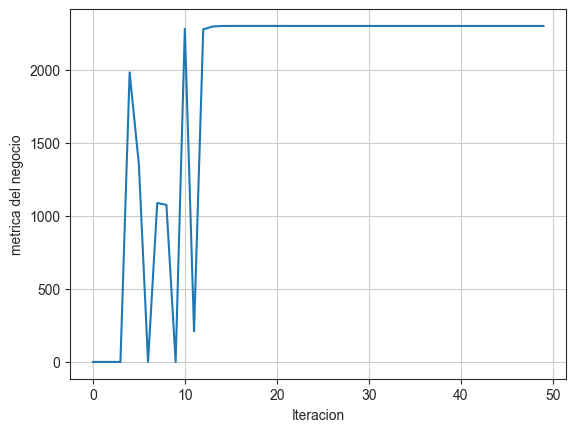

In [8]:
sns.set_style("ticks",{'axes.grid' : True})

chart_df = pd.DataFrame(data = -res.func_vals, columns=['y'])
chart_df.reset_index(inplace=True)
chart_df.columns = ['iteracion', 'metrica negocio']
g1 = sns.lineplot(data=chart_df, x="iteracion", y="metrica negocio")
g1.set(xlabel='Iteracion', ylabel='metrica del negocio')
plt.show()

In [7]:
[res.x, -res.fun]

[[0.969605298210795, 14, 0.0001, 0.8811907782965792], 2301.07]

### Utilizamos estos parámetros para crear un nuevo modelo

In [9]:
umbral_de_corte = res.x[0]
max_depth = res.x[1]
min_samples_split =  res.x[2]
max_features =  res.x[3]

#criterion='entropy'
criterion='gini'
#criterion='log_loss'

clf = DecisionTreeClassifier(
            criterion = criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=1
        )
_ = clf.fit(df_training_validacion, Y_df_training_validacion)


### Probamos los nuevos parámetros en testing

In [10]:
y_testing_pred = clf.predict_proba(X_testing)

df_y_testing_pred_proba = pd.DataFrame(y_testing_pred, columns = ['NO_prob', 'SI_prob'])
y_testing_pred = atu.evaluar_corte(df_y_testing_pred_proba['NO_prob'].values, umbral_de_corte, 'SI', 'NO')

metricas = atu.calcular_metricas(
    y_true = Y_testing['es_popular'].values, 
    y_pred = y_testing_pred, 
    labels=['NO', 'SI']
)

parametros = {
    'max_depth': max_depth,
    'umbral_corte': umbral_de_corte, 
    'min_samples_split': min_samples_split,
    'max_features': max_features
}
    
[metricas, parametros]

[{'true negatives': 11637,
  'true positives': 595,
  'false positives': 2329,
  'false negatives': 143,
  'accuracy': 0.8319,
  'recall': 0.8062,
  'precision': 0.2035,
  'specificity': 0.8332,
  'tasa falso positivo': 0.1668,
  'tasa falso negativo': 0.0102,
  'f1': 0.325,
  'metrica negocio': 2593.7669376693766,
  'metrica optima negocio': 4000.0},
 {'max_depth': 14,
  'umbral_corte': 0.969605298210795,
  'min_samples_split': 0.0001,
  'max_features': 0.8811907782965792}]

In [11]:
a_mlflow_u.log_experimento(
    host = 'http://localhost:5000', 
    nombre_experimento="AnalisisDeCervezas", 
    run_name="Sexta ejecucion", 
    descripcion="Rpart optimización gausiana CV + umbral_corte + max_depth + min_samples_split + maxfeatures + eliminacion de variables mas importante", 
    dataset_tag="validacion", 
    parametros=parametros, 
    metricas=metricas,
    model=clf, 
    artifact_path="model"
)

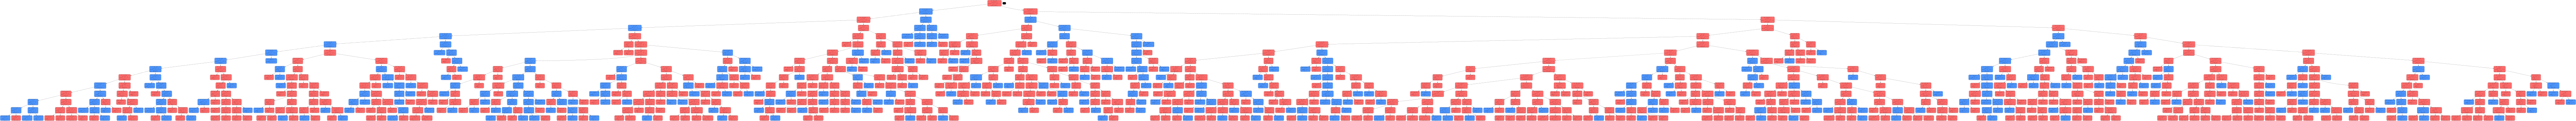

In [12]:
dot_data_value = agt.crear_arbol(clf, negative_class = 'NO', positive_class = 'SI', umbral = umbral_de_corte)

graph = pydotplus.graph_from_dot_data(dot_data_value)  
graph.set_size('"75,75"')
graph.write_png('img/modelo_5.png')
Image(graph.create_png())

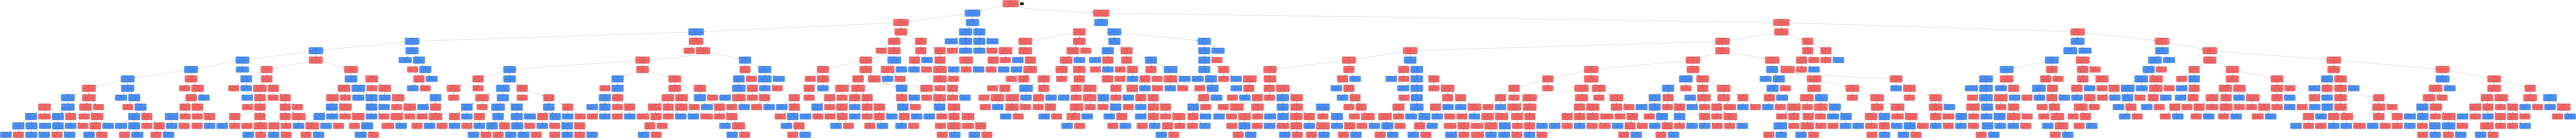

In [13]:
atu.prune_index(clf.tree_, 0, umbral_de_corte)

dot_data_value = agt.crear_arbol(clf, negative_class = 'NO', positive_class = 'SI', umbral = umbral_de_corte)

graph = pydotplus.graph_from_dot_data(dot_data_value)  
graph.set_size('"75,75"')
graph.write_png('img/modelo_5_prunned.png')
Image(graph.create_png())

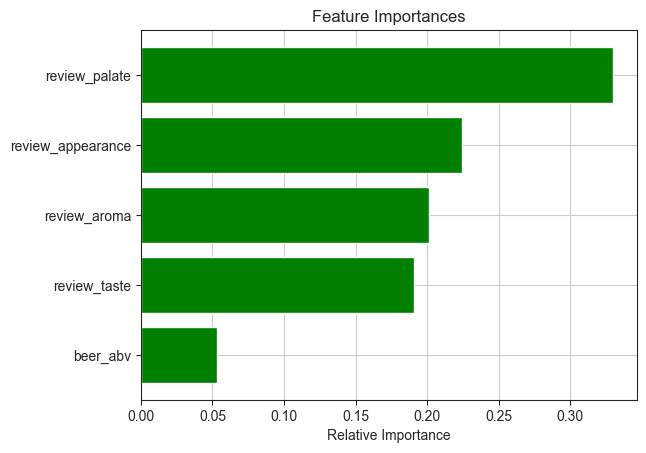

In [14]:
importances = clf.feature_importances_
indices = np.argsort(importances)
features = atributos
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()